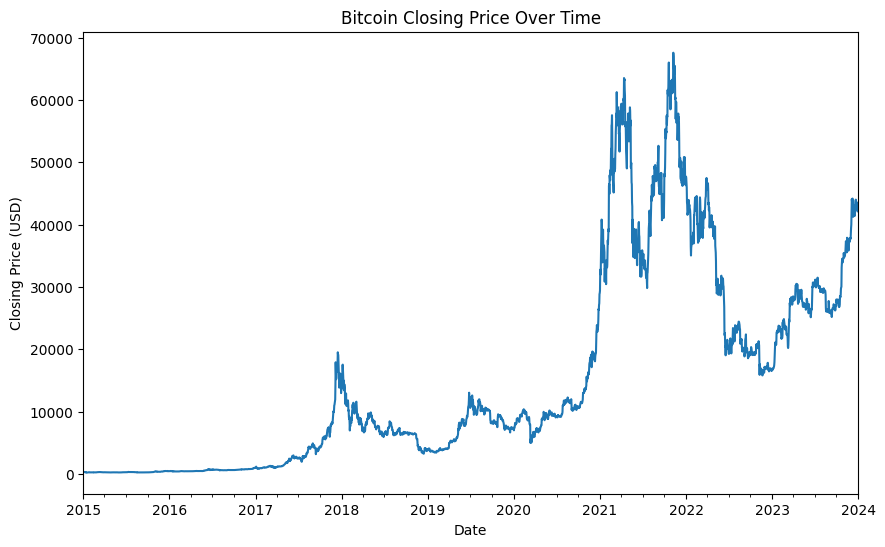

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
btc_data = pd.read_csv('BTC-USD.csv')

# Convert 'Date' to datetime and set as index
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)

# Selecting the 'Close' column and handling missing values if necessary
btc_close = btc_data['Close'].ffill()

# Plotting the historical closing prices
btc_close.plot(figsize=(10, 6))
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(btc_close.values.reshape(-1, 1))


In [36]:
def create_dataset(dataset, time_step=100):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(scaled_close, time_step)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

# Enhanced LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(time_step, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=1, verbose=1)


80/80 [==============================] - 9s 86ms/step - loss: 0.0053


In [46]:
from keras.models import load_model
model = load_model('btc_prediction_model.h5')

20/20 [==============================] - 1s 26ms/step


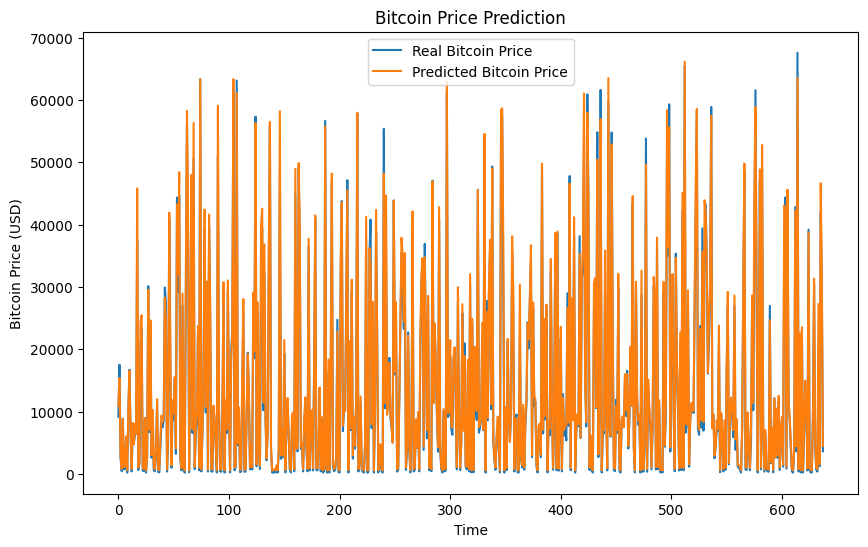

In [47]:
# Predict and inverse transform the scaled data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test_scaled, label='Real Bitcoin Price')
plt.plot(predictions, label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()


In [49]:
# Assuming 'predictions' and 'y_test' are already inverse transformed to their original scale

# Get the last date from the training set as a starting point for predictions
last_train_date = btc_close.index[-1] - pd.Timedelta(days=len(y_test))

# Create a date range for predictions
prediction_dates = pd.date_range(start=last_train_date, periods=len(predictions), freq='D')

# Create a dataframe for the predictions with corresponding dates
predictions_df = pd.DataFrame(data=predictions, index=prediction_dates, columns=['Predicted'])
actual_df = pd.DataFrame(data=y_test_scaled, index=prediction_dates, columns=['Actual'])


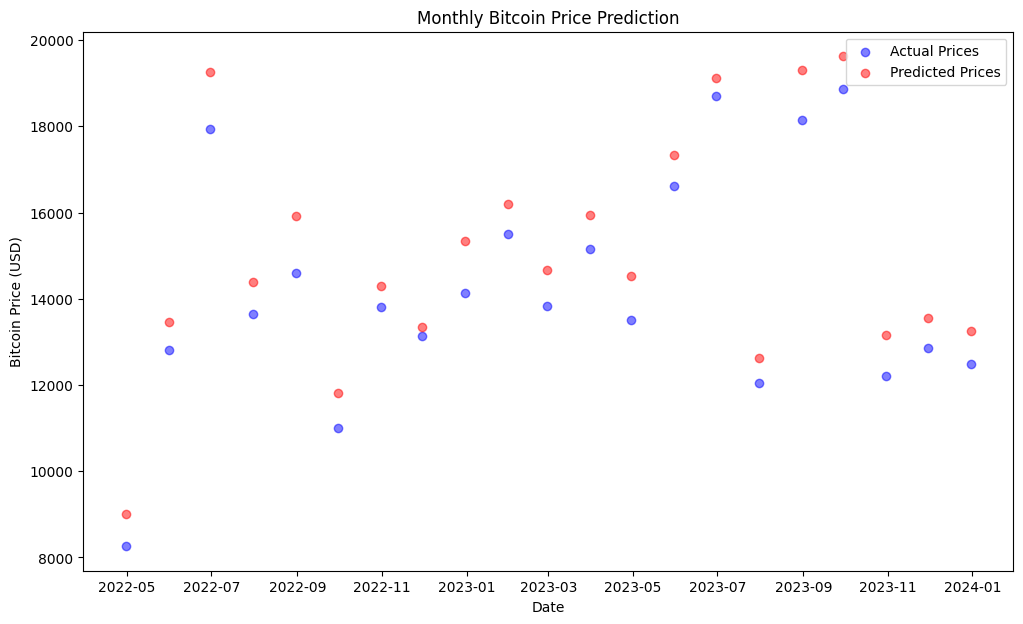

In [50]:
# Resample to monthly or yearly averages
monthly_predictions = predictions_df['Predicted'].resample('M').mean()
monthly_actual = actual_df['Actual'].resample('M').mean()

# Plotting the aggregated data
plt.figure(figsize=(12,7))
plt.scatter(monthly_actual.index, monthly_actual, color='blue', label='Actual Prices', alpha=0.5)
plt.scatter(monthly_predictions.index, monthly_predictions, color='red', label='Predicted Prices', alpha=0.5)
plt.title('Monthly Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


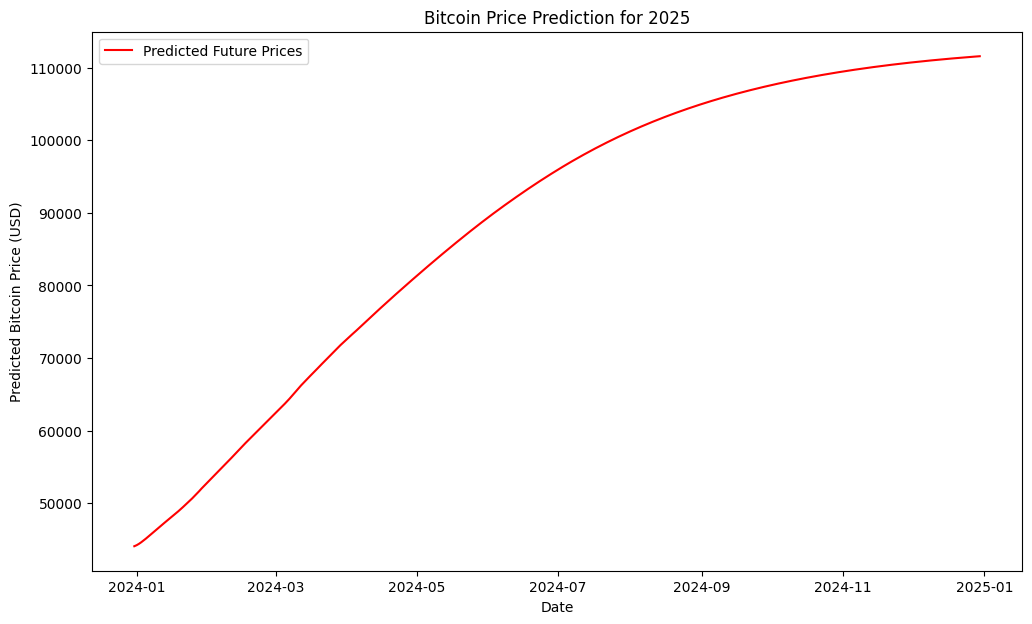

In [51]:
# Define the date range for the prediction
start_date = pd.to_datetime('2023-12-31')  # End of the last date with actual data
end_date = pd.to_datetime('2024-12-31')  # End of 2025

# Number of days to predict
num_days = (end_date - start_date).days

# Get the last `time_step` days from the dataset as the base for future predictions
input_seq = btc_close[-time_step:].values.reshape(-1, 1)
input_seq = scaler.transform(input_seq)  # Assuming 'scaler' is your MinMaxScaler object

# List to hold the predictions
future_predictions = []

# Loop for each day in the prediction range
for _ in range(num_days):
    # Reshape the input for LSTM prediction
    lstm_input = input_seq[-time_step:].reshape(1, time_step, 1)
    
    # Predict the next price
    predicted_price = model.predict(lstm_input)
    
    # Append the prediction to the list
    future_predictions.append(scaler.inverse_transform(predicted_price)[0, 0])
    
    # Update the input sequence with the predicted price
    input_seq = np.append(input_seq, predicted_price, axis=0)

# Create a date range for the predictions
future_dates = pd.date_range(start=start_date, periods=num_days, freq='D')

# Create a dataframe for the predictions with corresponding dates
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted'])

# Plot the future predictions
plt.figure(figsize=(12, 7))
plt.plot(future_predictions_df.index, future_predictions_df['Predicted'], color='red', label='Predicted Future Prices')
plt.title('Bitcoin Price Prediction for 2025')
plt.xlabel('Date')
plt.ylabel('Predicted Bitcoin Price (USD)')
plt.legend()
plt.show()


1/1 [==============================] - 0s 17ms/step


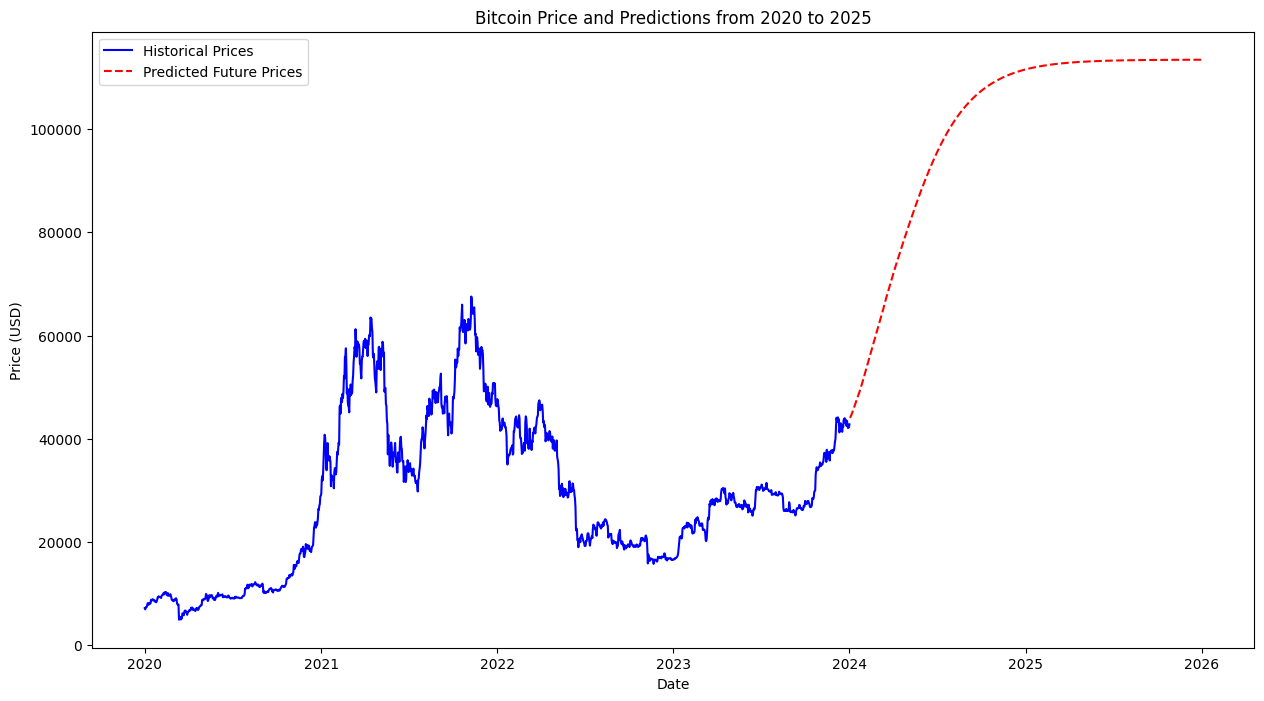

In [52]:
# Define the target year
target_year = 2025  # You can change this to the year you want

# Step 1: Extract historical data from 2020 onwards
historical_data = btc_close[btc_close.index.year >= 2020]

# Calculate the number of days to predict based on the target year
last_historical_date = historical_data.index[-1]
end_prediction_date = pd.Timestamp(year=target_year, month=12, day=31)
num_days = (end_prediction_date - last_historical_date).days

# Step 2: Generate predictions for the future up to the target year

# Prepare the input sequence with the last known data points
input_seq = historical_data[-time_step:].values.reshape(-1, 1)
input_seq = scaler.transform(input_seq)

# Predict future prices
future_predictions = []
for _ in range(num_days):
    lstm_input = input_seq[-time_step:].reshape(1, time_step, 1)
    predicted_price = model.predict(lstm_input)
    future_predictions.append(scaler.inverse_transform(predicted_price)[0, 0])
    input_seq = np.append(input_seq, predicted_price, axis=0)

# Create a DataFrame for the future predictions with corresponding dates
future_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=num_days, freq='D')
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted'])

# Step 3: Combine historical and predicted data into one DataFrame
combined_data = historical_data.to_frame(name='Actual')
combined_data = combined_data.join(future_predictions_df, how='outer')

# Step 4: Plot the combined data
plt.figure(figsize=(15, 8))
plt.plot(combined_data.index, combined_data['Actual'], label='Historical Prices', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted Future Prices', color='red', linestyle='--')
plt.title(f'Bitcoin Price and Predictions from 2020 to {target_year}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [43]:
# model.save('enahnced_3.h5')  # This saves the model in HDF5 format

/Users/zeyadwagdy/.pyenv/versions/3.11.7/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Using the Generated Model btc_prediction_model.h5**


In [53]:
import pandas as pd

def predict_price(input_date):
    # Convert input_date to pandas.Timestamp for comparison
    input_date = pd.Timestamp(input_date)

    # Check if the input date is within the range of your model's prediction
    if input_date < historical_data.index[0] or input_date > future_predictions_df.index[-1]:
        return "Date out of prediction range"

    if input_date in future_predictions_df.index:
        # Prediction for a future date
        predicted_price = future_predictions_df.loc[input_date]['Predicted']
    else:
        # Historical actual price
        predicted_price = historical_data.loc[input_date]['Actual']

    return predicted_price


In [54]:
import tkinter as tk
from datetime import datetime

def get_date():
    # Retrieve the date from the entry field
    date_string = date_entry.get()
    
    try:
        # Parse the date string into a datetime object
        entered_date = datetime.strptime(date_string, '%Y-%m-%d').date()
        
        # Call the prediction function
        predicted_price = predict_price(entered_date)

        # Clear the previous result
        result_label.config(text="")

        # Display the result
        result_label.config(text=f"The predicted price for {entered_date} is {predicted_price}")
        
    except ValueError:
        result_label.config(text="Please enter a valid date in YYYY-MM-DD format.")


# Set up the Tkinter window
window = tk.Tk()
window.title("Bitcoin Price Prediction")

# Set the window size and position it in the center of the screen
window.geometry("400x200")
window.eval('tk::PlaceWindow . center')

# Create a label, entry field, and button
label = tk.Label(window, text="Enter a date (YYYY-MM-DD):")
label.pack()

date_entry = tk.Entry(window)
date_entry.pack()

submit_button = tk.Button(window, text="Get Prediction", command=get_date)
submit_button.pack()

# Create a label to display the result
result_label = tk.Label(window, text="")
result_label.pack()

# Start the Tkinter event loop
window.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/zeyadwagdy/.pyenv/versions/3.11.7/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/g9/hvz52lq90tnb_z36w46sv2n00000gn/T/ipykernel_2295/3191392762.py", line 13, in get_date
    predicted_price = predict_price(entered_date)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/g9/hvz52lq90tnb_z36w46sv2n00000gn/T/ipykernel_2295/3885941802.py", line 16, in predict_price
    predicted_price = historical_data.loc[input_date]['Actual']
                      ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^
IndexError: invalid index to scalar variable.
